<a href="https://colab.research.google.com/github/olumideaeo/gensim/blob/master/lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [134]:
!pip install text_hammer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [135]:
!pip install gensim==3.8.3
!pip install keras --upgrade
!pip install pandas --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [136]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [137]:
# importing the dataset 
df_raw=pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/rawtext.txt')
df_train = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Train_Kanglish.csv')
df_test = pd.read_csv('/content/drive/MyDrive/CoLI-Kanglish/Test_withoutLabels_Kanglish.csv')


In [138]:
df_raw

,text
0,klm
1,movie nalli continuation illa
2,nijavagalu super guru
3,concept making camera work yalha changi but ma...
4,nice but voice yar act madidaro avr atrane dub...
...,...
72129,dandapinda charche ivra mane
72130,siddaramaiah boss fan
72131,power boss fan
72132,aasthi koti madoke farmer name politicians


In [139]:
df_train

,word,tag
0,anusthu,kn
1,woww,en
2,staying,en
3,near,en
4,hostel,en
...,...,...
14842,hiremadtara,en-kn
14843,solutionila,en-kn
14844,accessmadkoli,en-kn
14845,glasshakisi,en-kn


In [140]:
df_train.iloc[:,-1:]

,tag
0,kn
1,en
2,en
3,en
4,en
...,...
14842,en-kn
14843,en-kn
14844,en-kn
14845,en-kn


In [141]:
df_train['tag'].value_counts()

kn          6526
en          4469
other       1663
en-kn       1379
name         708
location     102
Name: tag, dtype: int64

In [142]:
df_train.drop_duplicates(inplace = True, keep = 'first')

In [143]:
df_train.describe(include = 'all')

,word,tag
count,14769,14769
unique,14762,6
top,mindalli,kn
freq,2,6494


Text(0.5, 1.0, 'Distribution of tags in dataset')

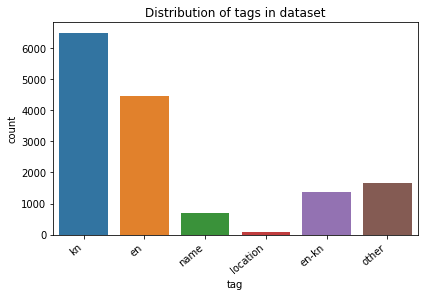

In [144]:
import seaborn as sns
ax = sns.countplot(data = df_train, x = 'tag')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right", fontsize=10)
plt.rcParams["figure.figsize"] = (15, 8)
plt.tight_layout()
plt.title('Distribution of tags in dataset')

In [145]:
!pip uninstall tensorflow

In [146]:
!pip install tf-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [147]:
# WORD2VEC 
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 30
EPOCHS = 5
BATCH_SIZE = 64

In [148]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            size=W2V_SIZE,
                                            workers=8)

In [149]:
%%time
documents = df_train.word 

CPU times: user 223 µs, sys: 15 µs, total: 238 µs
Wall time: 283 µs


In [150]:
w2v_model = gensim.models.word2vec.Word2Vec(window=W2V_WINDOW, 
                                            min_count=W2V_MIN_COUNT,
                                            size=W2V_SIZE, 
                                            workers=8)

In [151]:
w2v_model.build_vocab(documents)

In [152]:
words = w2v_model.wv.vocab.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30


In [153]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 2.44 s, sys: 98.8 ms, total: 2.54 s
Wall time: 1.83 s


(562452, 3364512)

In [154]:
from keras_preprocessing.sequence import pad_sequences

In [155]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.word)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 14763
CPU times: user 127 ms, sys: 2 ms, total: 129 ms
Wall time: 129 ms


In [156]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.word), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.word), maxlen=SEQUENCE_LENGTH)

CPU times: user 175 ms, sys: 0 ns, total: 175 ms
Wall time: 177 ms


In [157]:
labels = df_train.tag.unique().tolist()
labels

['kn', 'en', 'name', 'location', 'en-kn', 'other']

In [158]:
df_test

,word
0,alla
1,kopista
2,baruthe
3,coolagiru
4,madhuswamy
...,...
4580,kalena
4581,horg
4582,tarovanthaa
4583,banglore


In [159]:
encoder = LabelEncoder()
encoder.fit(df_train.tag.tolist())

y_train = encoder.transform(df_train.tag.tolist())
#y_test = encoder.transform(df_test.tag.tolist())

y_train = y_train.reshape(-1,1)
#y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)

y_train (14769, 1)


In [160]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(14763, 300)


In [161]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [162]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 30, 300)           4428900   
                                                                 
 dropout_2 (Dropout)         (None, 30, 300)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100)               160400    
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 4,589,401
Trainable params: 160,501
Non-trainable params: 4,428,900
_________________________________________________________________


In [163]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [164]:
callbacks = [ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_acc', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

In [185]:
prediction = model.predict(x_test)
df_test['tag']= prediction
df_test.to_csv('CIC-O.csv',index=None)

144/144 [==============================] - 3s 20ms/step


In [193]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


x_train=df_train.word
y_tag=df_train.tag
x_word_num=list(x_train)
char_vectorizer = TfidfVectorizer(sublinear_tf=bool, strip_accents='unicode',min_df=0., analyzer='char_wb', ngram_range=(1,2),input='content', encoding='utf-8', decode_error='replace', lowercase=bool, preprocessor=None, token_pattern='(?u)\b\w\w+\b', max_df=1.0, max_features=None, vocabulary=None, binary=bool, norm='l1', use_idf=bool, smooth_idf=True)
x_word_num_train=char_vectorizer.fit_transform(x_word_num)


In [195]:
x_test=df_test.word
x_word_num1=list(x_test)
x_word_num_test=char_vectorizer.transform(x_word_num1)

In [196]:
x_word_train, x_word_test, y_tag_train, y_tag_test=train_test_split(x_word_num_train, y_tag, test_size=0.3, random_state=10, stratify=y_tag)

In [207]:
from sklearn.ensemble import RandomForestClassifier
rmfr = RandomForestClassifier()
rmfr.fit(x_word_train,y_tag_train)
predrmfr = rmfr.predict(x_word_test)

print("Confusion Matrix for Random Forest Classifier:")
print(confusion_matrix(y_tag_test,predrmfr))
print("Score:",round(accuracy_score(y_tag_test,predrmfr)*100,2))
print("Classification Report:",classification_report(y_tag_test,predrmfr))

Confusion Matrix for Random Forest Classifier:
[[1109   14  183    0    4   23]
 [  56  229  124    0    0    0]
 [  89   32 1780    0    8   39]
 [   5    1   22    2    0    0]
 [  34    7  119    0   43    9]
 [  94    7  291    0    6  101]]
Score: 73.66
Classification Report:               precision    recall  f1-score   support

          en       0.80      0.83      0.82      1333
       en-kn       0.79      0.56      0.66       409
          kn       0.71      0.91      0.80      1948
    location       1.00      0.07      0.12        30
        name       0.70      0.20      0.32       212
       other       0.59      0.20      0.30       499

    accuracy                           0.74      4431
   macro avg       0.76      0.46      0.50      4431
weighted avg       0.73      0.74      0.71      4431



In [210]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier()
mlp.fit(x_word_train,y_tag_train)
predmlp = mlp.predict(x_word_test)
print("Confusion Matrix for Multilayer Perceptron Classifier:")
print(confusion_matrix(y_tag_test,predmlp))
print("Score:",round(accuracy_score(y_tag_test,predmlp)*100,2))
print("Classification Report:")
print(classification_report(y_tag_test,predmlp))

Confusion Matrix for Multilayer Perceptron Classifier:
[[1074   29  163    2    8   57]
 [  40  291   68    0    5    5]
 [ 101   36 1682    0   36   93]
 [   4    4   13    3    5    1]
 [  37    3   76    1   74   21]
 [  82   14  182    3   28  190]]
Score: 74.79
Classification Report:
              precision    recall  f1-score   support

          en       0.80      0.81      0.80      1333
       en-kn       0.77      0.71      0.74       409
          kn       0.77      0.86      0.81      1948
    location       0.33      0.10      0.15        30
        name       0.47      0.35      0.40       212
       other       0.52      0.38      0.44       499

    accuracy                           0.75      4431
   macro avg       0.61      0.54      0.56      4431
weighted avg       0.73      0.75      0.74      4431



/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [209]:
from sklearn.tree import DecisionTreeClassifier

dec_tree = DecisionTreeClassifier()
dec_tree.fit(x_word_train,y_tag_train)
y_predict=dec_tree.predict(x_word_test)
from sklearn.metrics import confusion_matrix, classification_report
print(confusion_matrix(y_tag_test,y_predict))
print(classification_report(y_tag_test,y_predict))


[[ 981   56  203    4   17   72]
 [  45  219  113    3    7   22]
 [ 197   98 1407    7   64  175]
 [   5    5   11    3    5    1]
 [  32   14   78    4   50   34]
 [  92   21  205    2   30  149]]
              precision    recall  f1-score   support

          en       0.73      0.74      0.73      1333
       en-kn       0.53      0.54      0.53       409
          kn       0.70      0.72      0.71      1948
    location       0.13      0.10      0.11        30
        name       0.29      0.24      0.26       212
       other       0.33      0.30      0.31       499

    accuracy                           0.63      4431
   macro avg       0.45      0.44      0.44      4431
weighted avg       0.63      0.63      0.63      4431

